### import needed libraries

In [1]:
import os
import PIL as Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adamax
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('modules loaded')

2024-07-27 18:12:03.948657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 18:12:03.948753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 18:12:04.096461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


### read data

In [2]:
train_data_dir='/kaggle/input/alpaca-dataset-small/dataset'
filepaths=[]
labels=[]
folds=os.listdir(train_data_dir)
for fold in folds:
    fpath=os.path.join(train_data_dir,fold)
    fpaths=os.listdir(fpath)
    for i in fpaths:
        fi_path=os.path.join(fpath,i)
        filepaths.append(fi_path)
        labels.append(fold)
fseries=pd.Series(filepaths,name='filepaths')   
lseries=pd.Series(labels,name='labels')
df=pd.concat([fseries,lseries],axis=1)  
df

filepaths      labels
0    /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
1    /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
2    /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
3    /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
4    /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
..                                                 ...         ...
322  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
323  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
324  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
325  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
326  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca

[327 rows x 2 columns]

### visulization

In [3]:
count =df['labels'].value_counts()
count

labels
not alpaca    185
alpaca        142
Name: count, dtype: int64

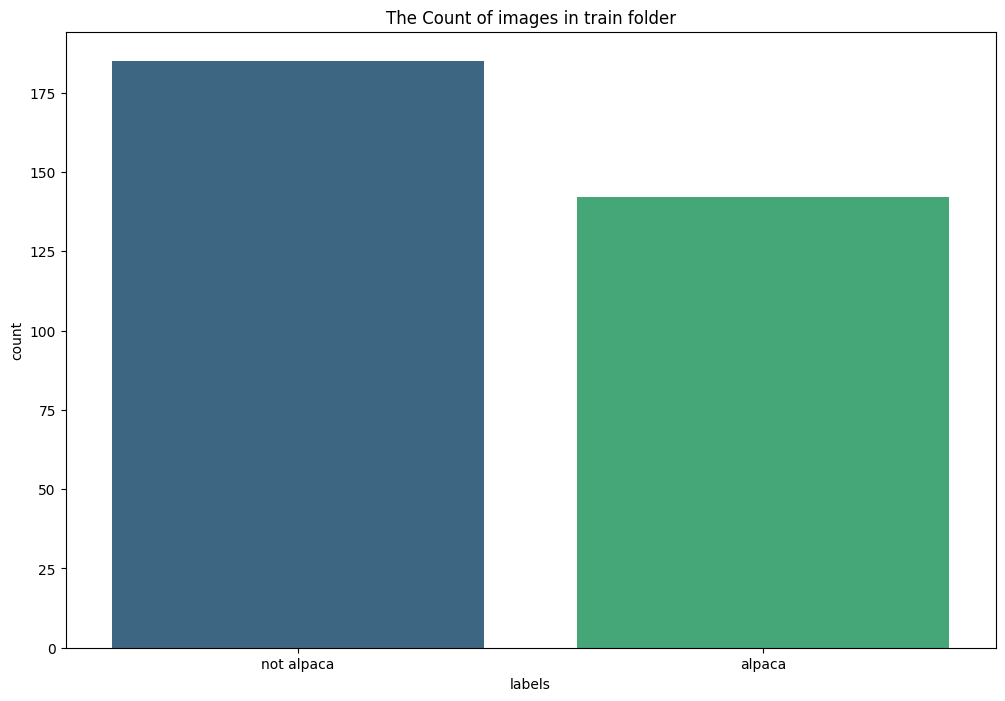

In [4]:
plt.figure(figsize=(12,8))
sns.barplot(x=count.index,y=count.values,palette='viridis')
plt.title('The Count of images in train folder')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

### split data

In [5]:
train_df , dummy_df=train_test_split(df,test_size=0.2,shuffle=True,random_state=42)
valid_df,test_df=train_test_split(df,test_size=0.4,shuffle=True,random_state=42)

In [6]:
train_df

filepaths      labels
183  /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
17   /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
24   /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
132  /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
113  /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
..                                                 ...         ...
188  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
71   /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
106  /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
270  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
102  /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca

[261 rows x 2 columns]

In [7]:
test_df

filepaths      labels
231  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
110  /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
250  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
9    /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
93   /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
..                                                 ...         ...
185  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
69   /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
97   /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
165  /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
68   /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca

[131 rows x 2 columns]

In [8]:
valid_df

filepaths      labels
23   /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
37   /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
237  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
67   /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
262  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
..                                                 ...         ...
188  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
71   /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
106  /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca
270  /kaggle/input/alpaca-dataset-small/dataset/alp...      alpaca
102  /kaggle/input/alpaca-dataset-small/dataset/not...  not alpaca

[196 rows x 2 columns]

### create image generator

In [9]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 261 validated image filenames belonging to 2 classes.
Found 196 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.


### sample of data

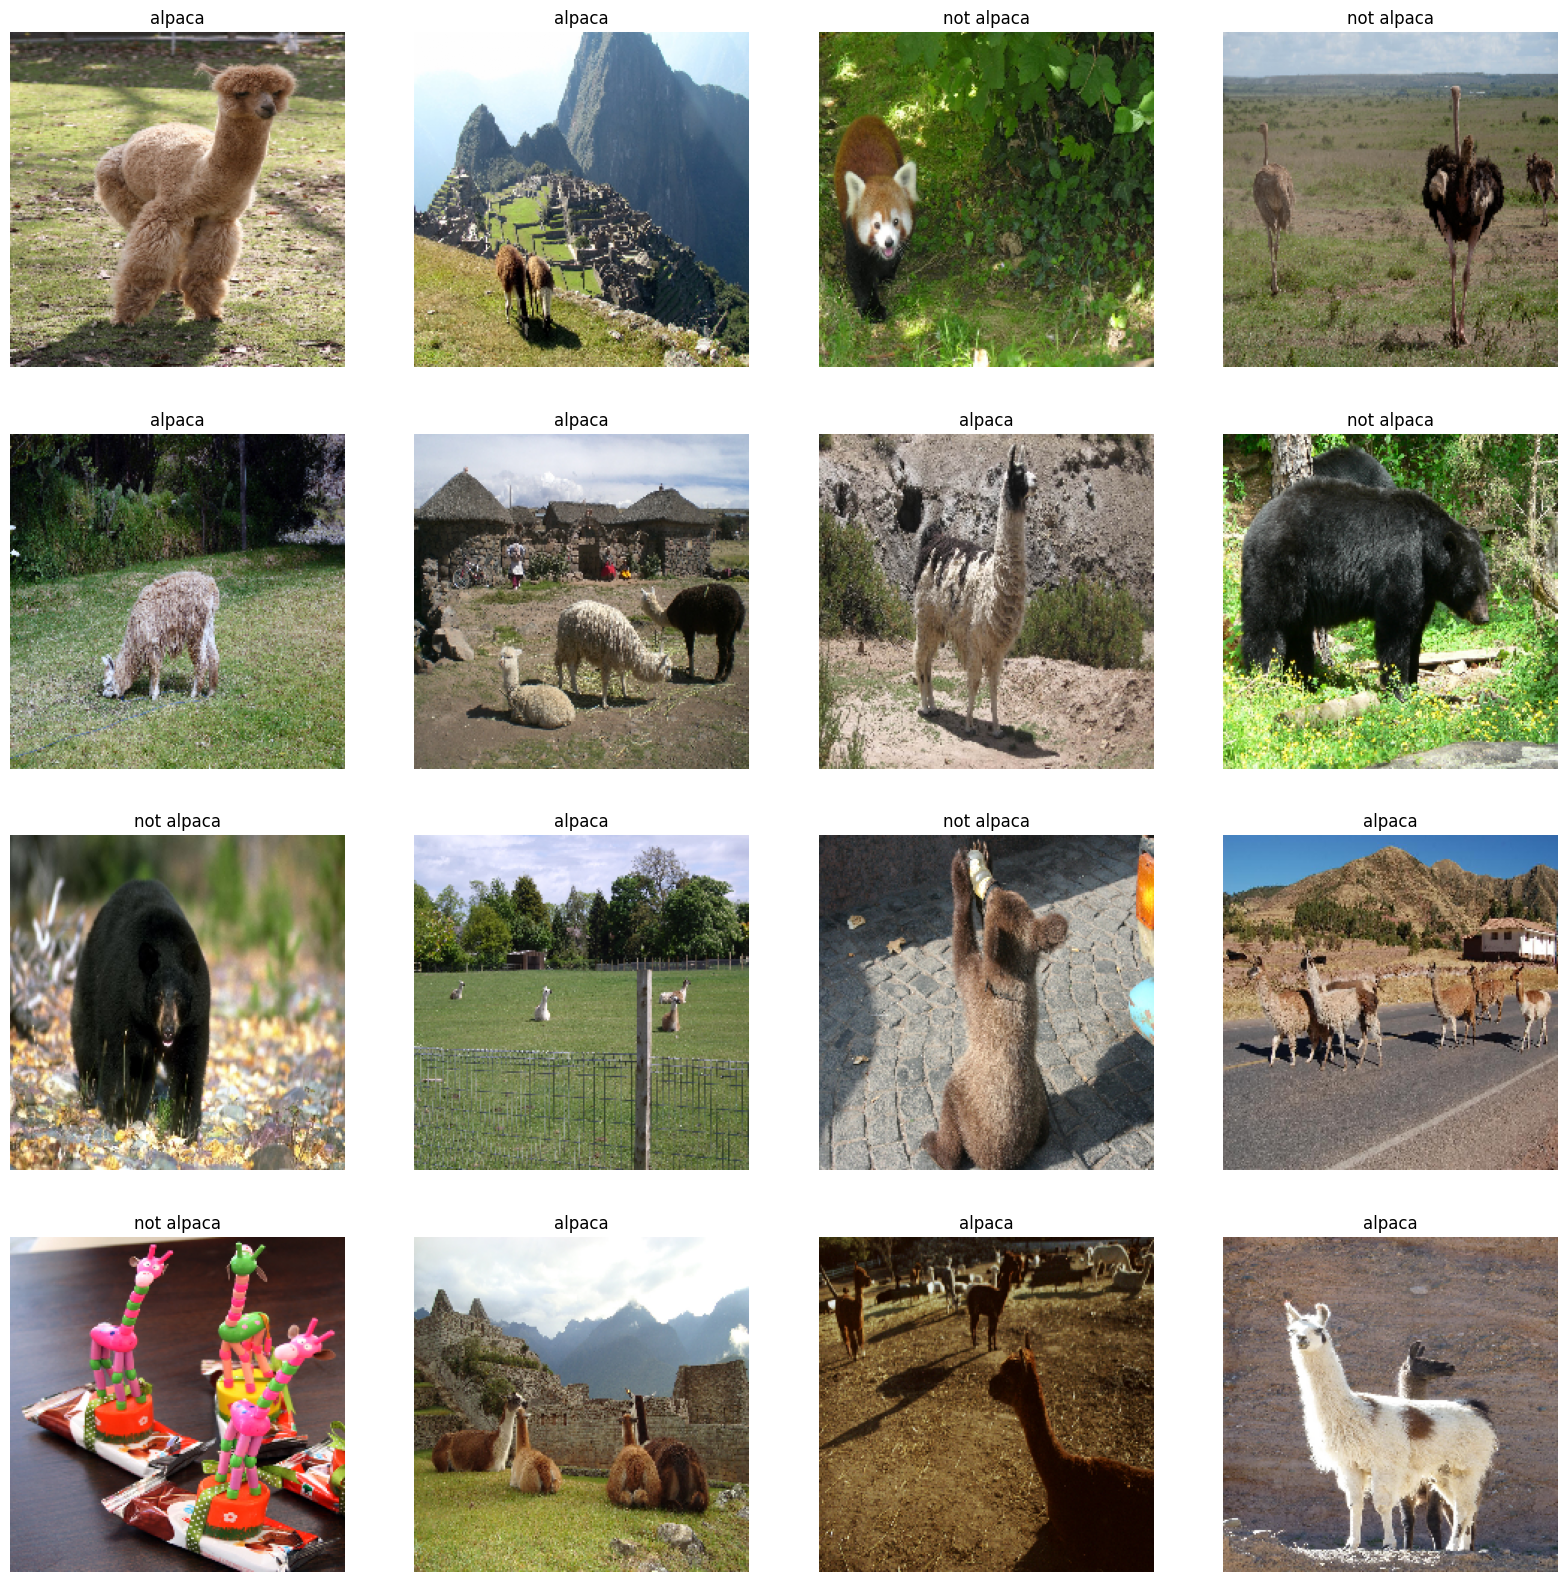

In [10]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

### structure to model1

In [11]:
base_model=keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(2,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
history=model.fit(train_gen,epochs=10,validation_data=valid_gen,shuffle=False,validation_steps=None)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/17 ━━━━━━━━━━━━━━━━━━━━ 23:22 88s/step - accuracy: 0.3125 - loss: 1.3590

I0000 00:00:1722104028.070297     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722104028.167441     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4801 - loss: 2.3666   

W0000 00:00:1722104086.453939     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.4866 - loss: 2.3370 - val_accuracy: 0.8571 - val_loss: 0.5885
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.9777 - loss: 0.0631 - val_accuracy: 0.9286 - val_loss: 0.3017
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9337 - val_loss: 0.2589
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.9996 - loss: 0.0094 - val_accuracy: 0.9745 - val_loss: 0.1324
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.9907 - loss: 0.0183 - val_accuracy: 0.9847 - val_loss: 0.0493
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.9977 - loss: 0.0052 - val_accuracy: 0.9898 - val_loss: 0.0432
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.9951 - loss: 0.0408 - val_accuracy: 0.9898 - val_loss: 0.0169
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.9977 - loss: 0.0043 - val_accuracy: 1.0000 - val_l

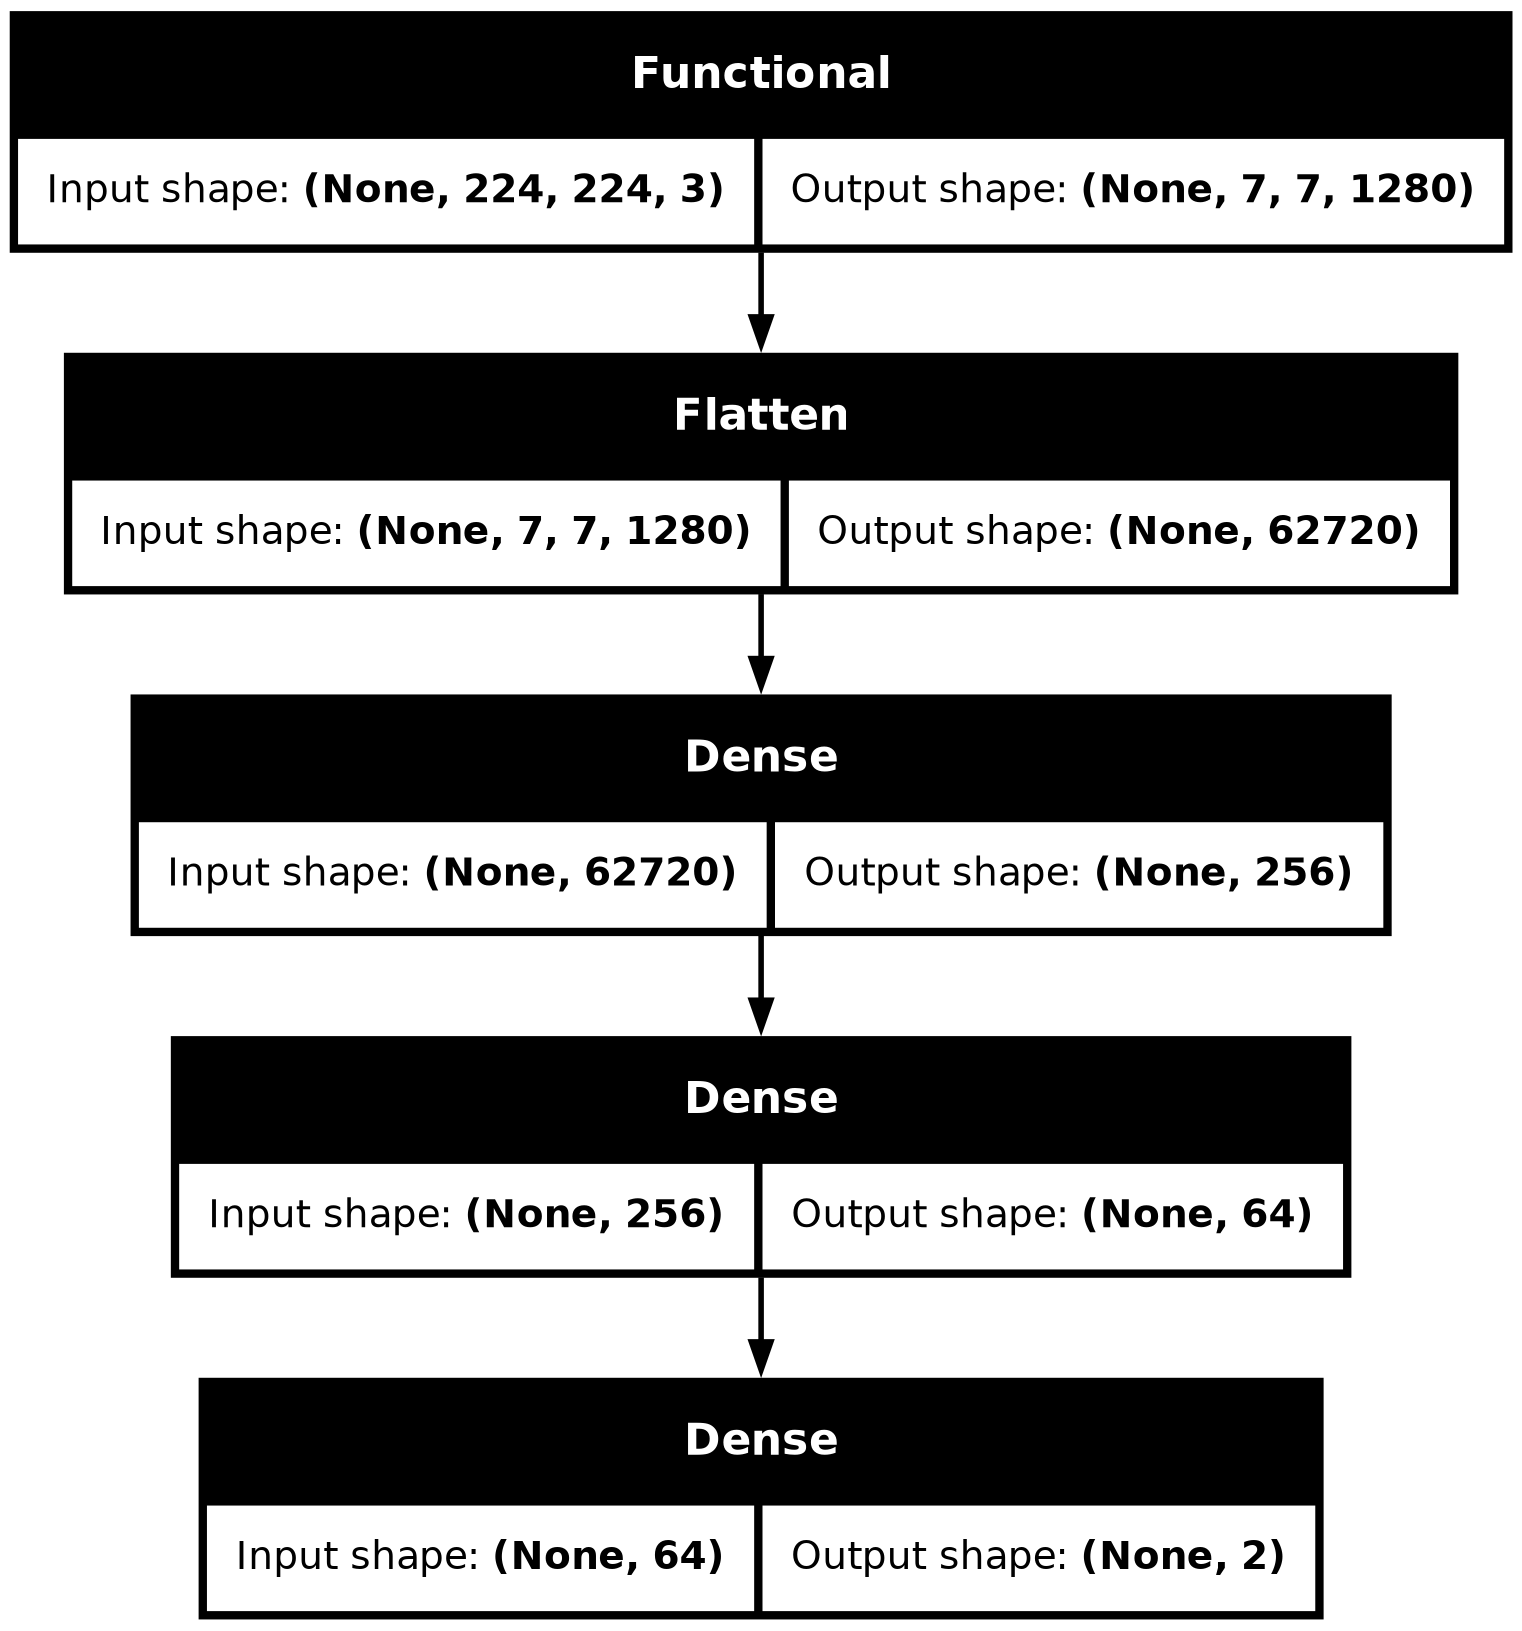

In [13]:
tf.keras.utils.plot_model(model,show_shapes=True)

### evalution 1

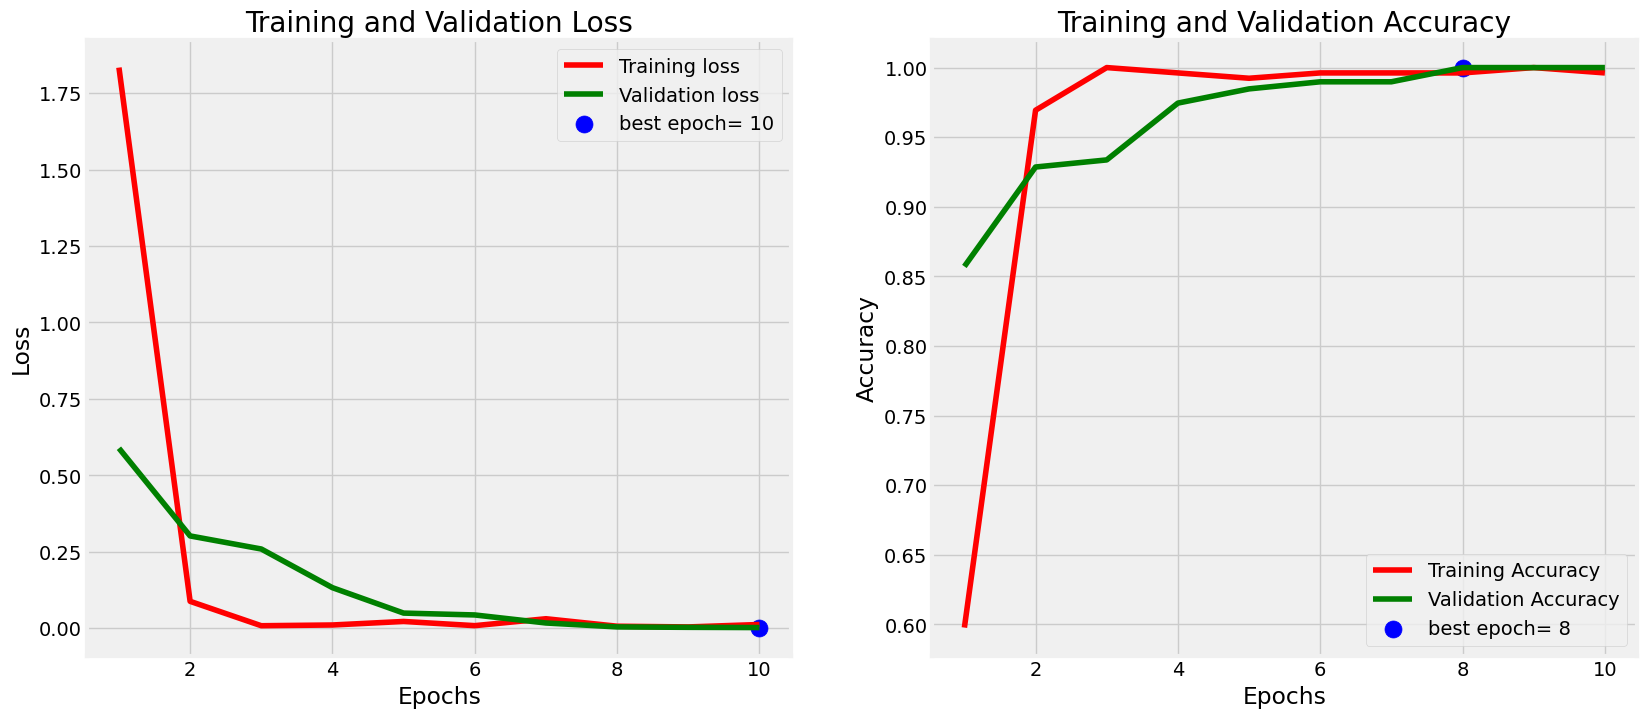

In [14]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 1.0000 - loss: 0.0016  


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 1.0000 - loss: 0.0018    
  1/131 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.7500 - loss: 1.8460

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8885 - loss: 0.5907   
Train Loss:  0.0014719449682161212
Train Accuracy:  1.0
--------------------
Valid Loss:  0.0019072082359343767
Valid Accuracy:  1.0
--------------------
Test Loss:  0.5630989074707031
Test Accuracy:  0.8931297659873962


In [16]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

W0000 00:00:1722104152.750433     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 799ms/step


### confusion matrix to model 1

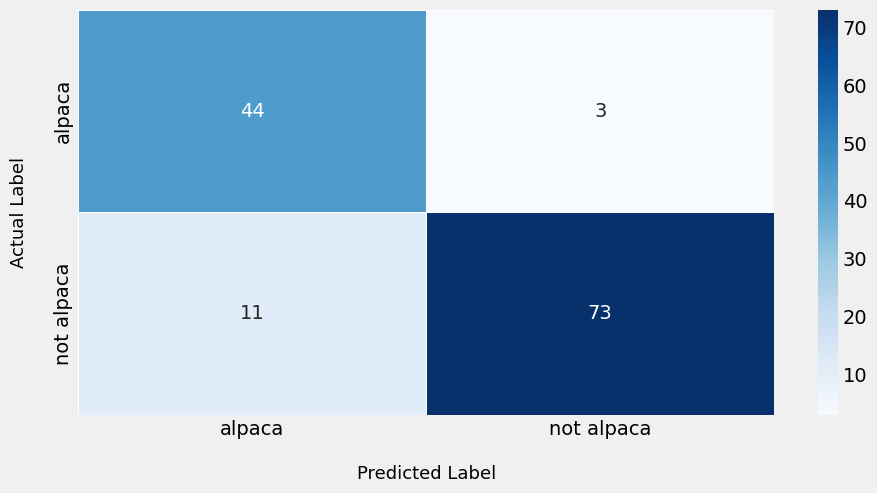

In [17]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

### structure to model 2

In [18]:
base_model=tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(64,activation='relu'),
    Dropout(0.25),
    Dense(2,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
history=model.fit(train_gen,epochs=20,validation_data=valid_gen,shuffle=False,validation_steps=None)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 415s 11s/step - accuracy: 0.5659 - loss: 8.2980 - val_accuracy: 0.5918 - val_loss: 73.8535
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - accuracy: 0.7716 - loss: 2.5294 - val_accuracy: 0.6378 - val_loss: 41.1163
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - accuracy: 0.7904 - loss: 1.8268 - val_accuracy: 0.8265 - val_loss: 4.8479
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - accuracy: 0.8251 - loss: 1.6052 - val_accuracy: 0.5816 - val_loss: 29.3061
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.8777 - loss: 1.3651 - val_accuracy: 0.6224 - val_loss: 19.2348
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - accuracy: 0.9525 - loss: 0.1246 - val_accuracy: 0.6378 - val_loss: 12.0936
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.9773 - loss: 0.1801 - val_accuracy: 0.6071 - val_loss: 8.4160
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.9525 - loss: 0.1514 - val_accurac

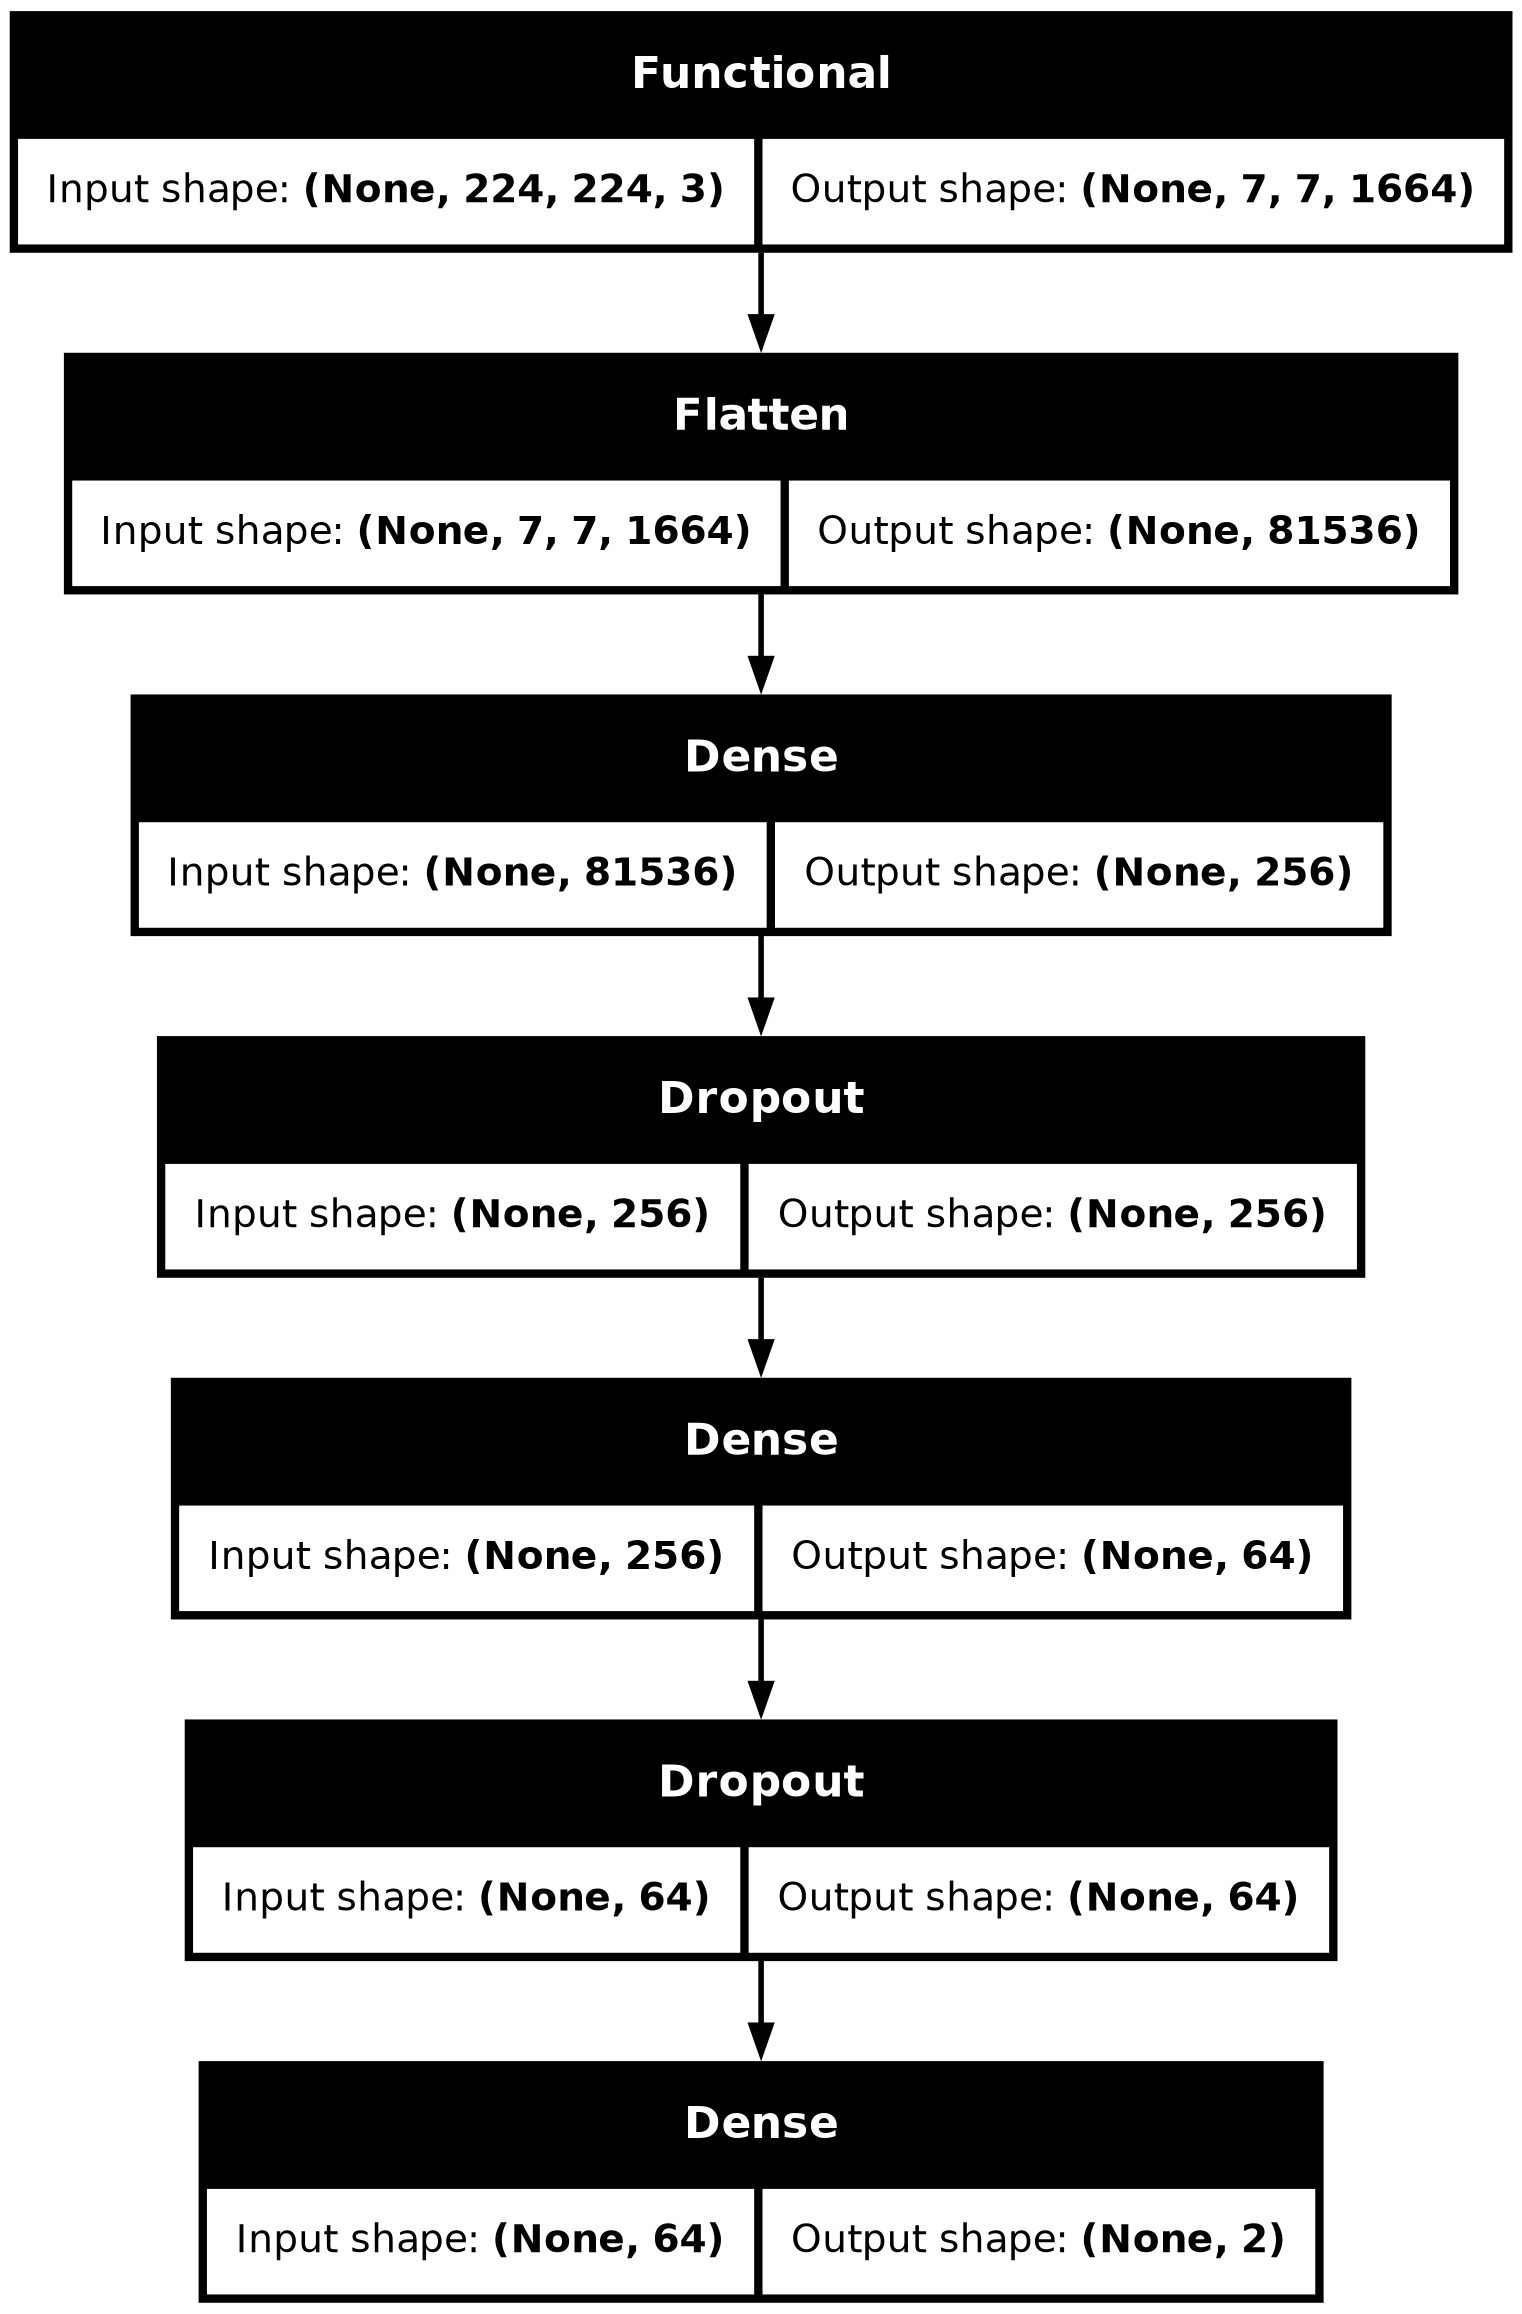

In [20]:
tf.keras.utils.plot_model(model,show_shapes=True)

### evalution 2

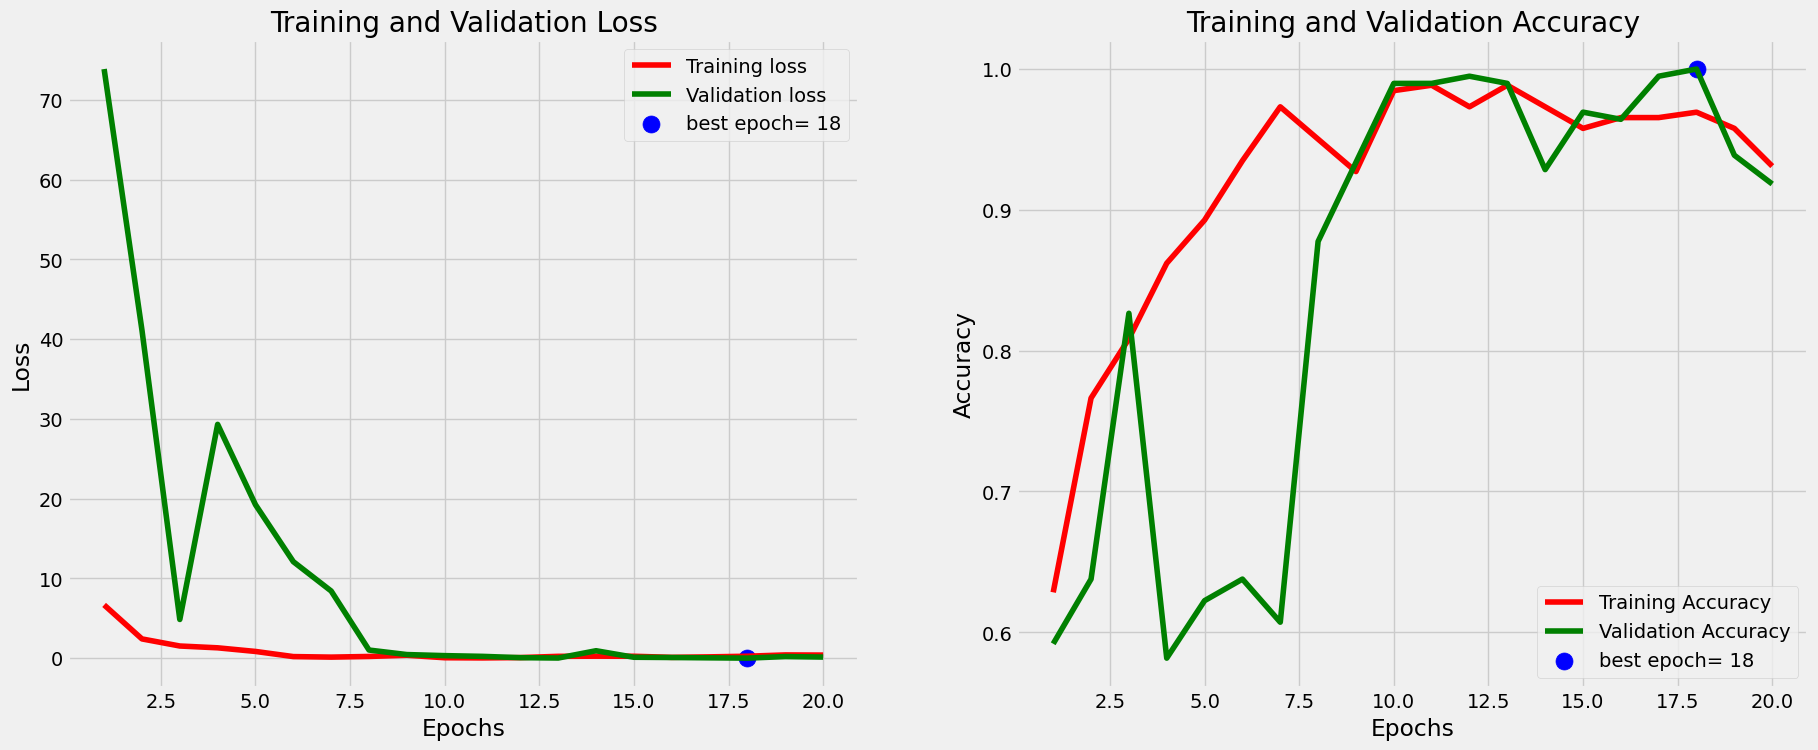

In [21]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [22]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.9231 - loss: 0.1274  


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9193 - loss: 0.1354  
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.8331 - loss: 0.4930
Train Loss:  0.1285025030374527
Train Accuracy:  0.9233716726303101
--------------------
Valid Loss:  0.13557040691375732
Valid Accuracy:  0.918367326259613
--------------------
Test Loss:  0.4656337797641754
Test Accuracy:  0.8396946787834167


In [23]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step 


### confusion matrix to model 2

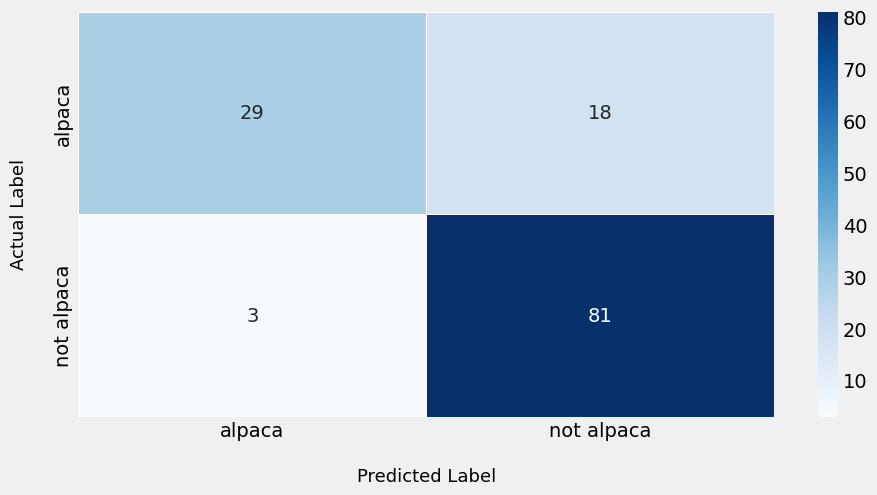

In [24]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

### structure to model 3

In [25]:
base_model=keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(64,activation='relu'),
    Dense(2,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
history=model.fit(train_gen,epochs=10,validation_data=valid_gen,shuffle=False,validation_steps=None)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.5875 - loss: 5.3114 - val_accuracy: 0.5153 - val_loss: 36.3143
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.7833 - loss: 1.5350 - val_accuracy: 0.5153 - val_loss: 58.4783
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.7981 - loss: 0.6955 - val_accuracy: 0.5306 - val_loss: 71.0035
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.9323 - loss: 0.1811 - val_accuracy: 0.5408 - val_loss: 41.1064
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.9450 - loss: 0.2480 - val_accuracy: 0.7143 - val_loss: 4.4564
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.9700 - loss: 0.0943 - val_accuracy: 0.8367 - val_loss: 1.0235
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.9771 - loss: 0.0758 - val_accuracy: 0.8622 - val_loss: 1.2092
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.9275 - loss: 0.1643 - val_accuracy:

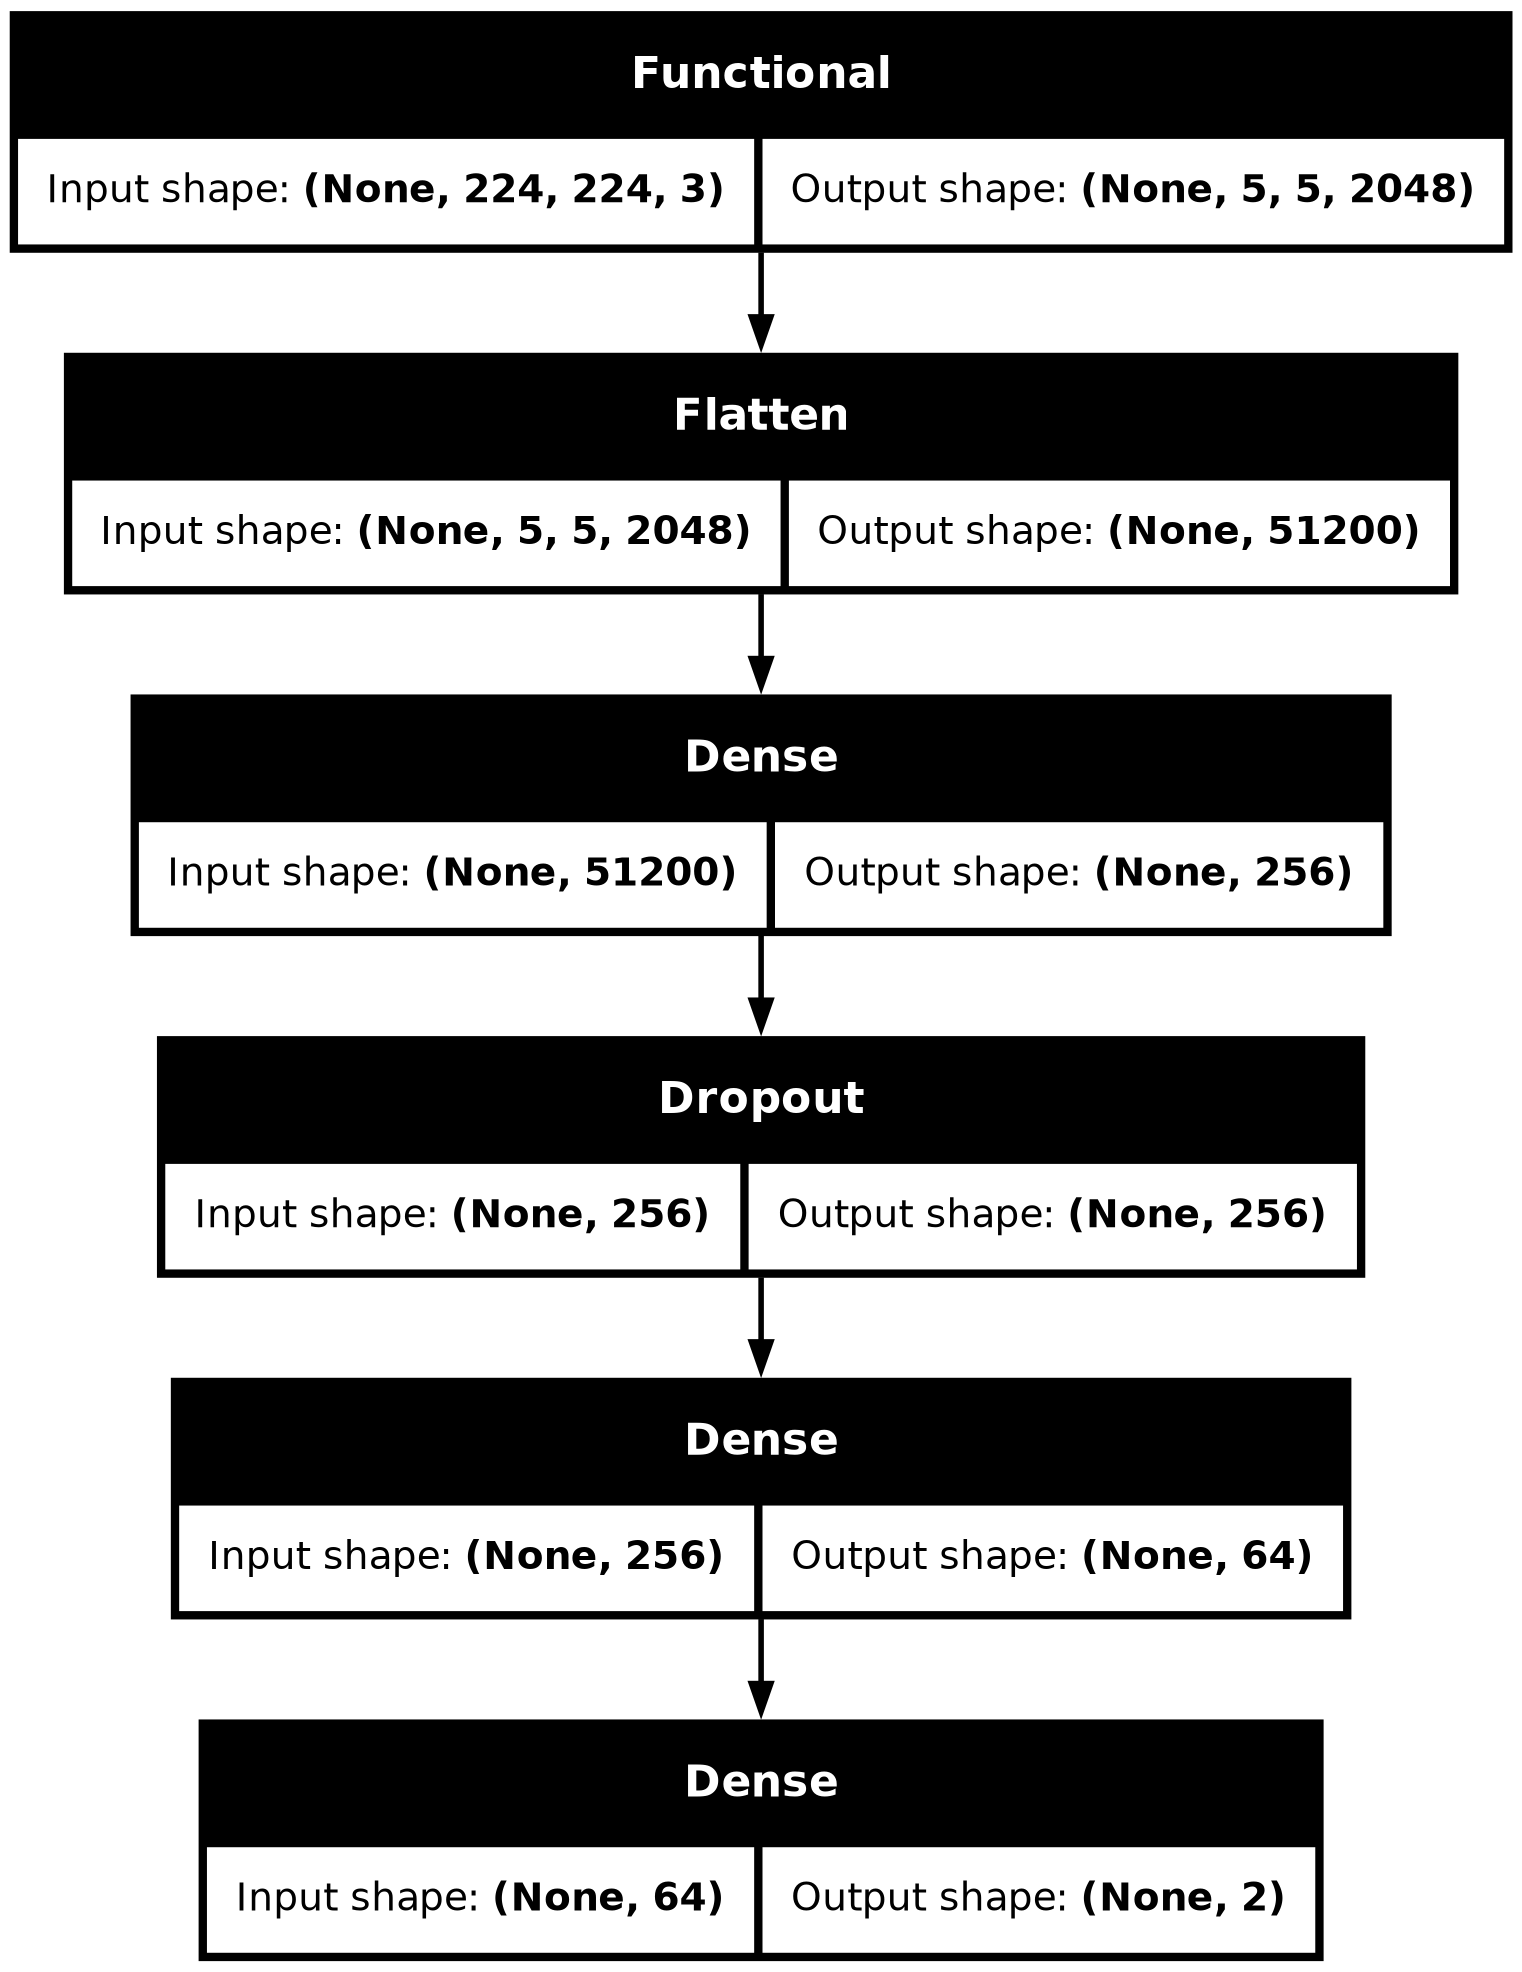

In [27]:
tf.keras.utils.plot_model(model,show_shapes=True)

### evalution

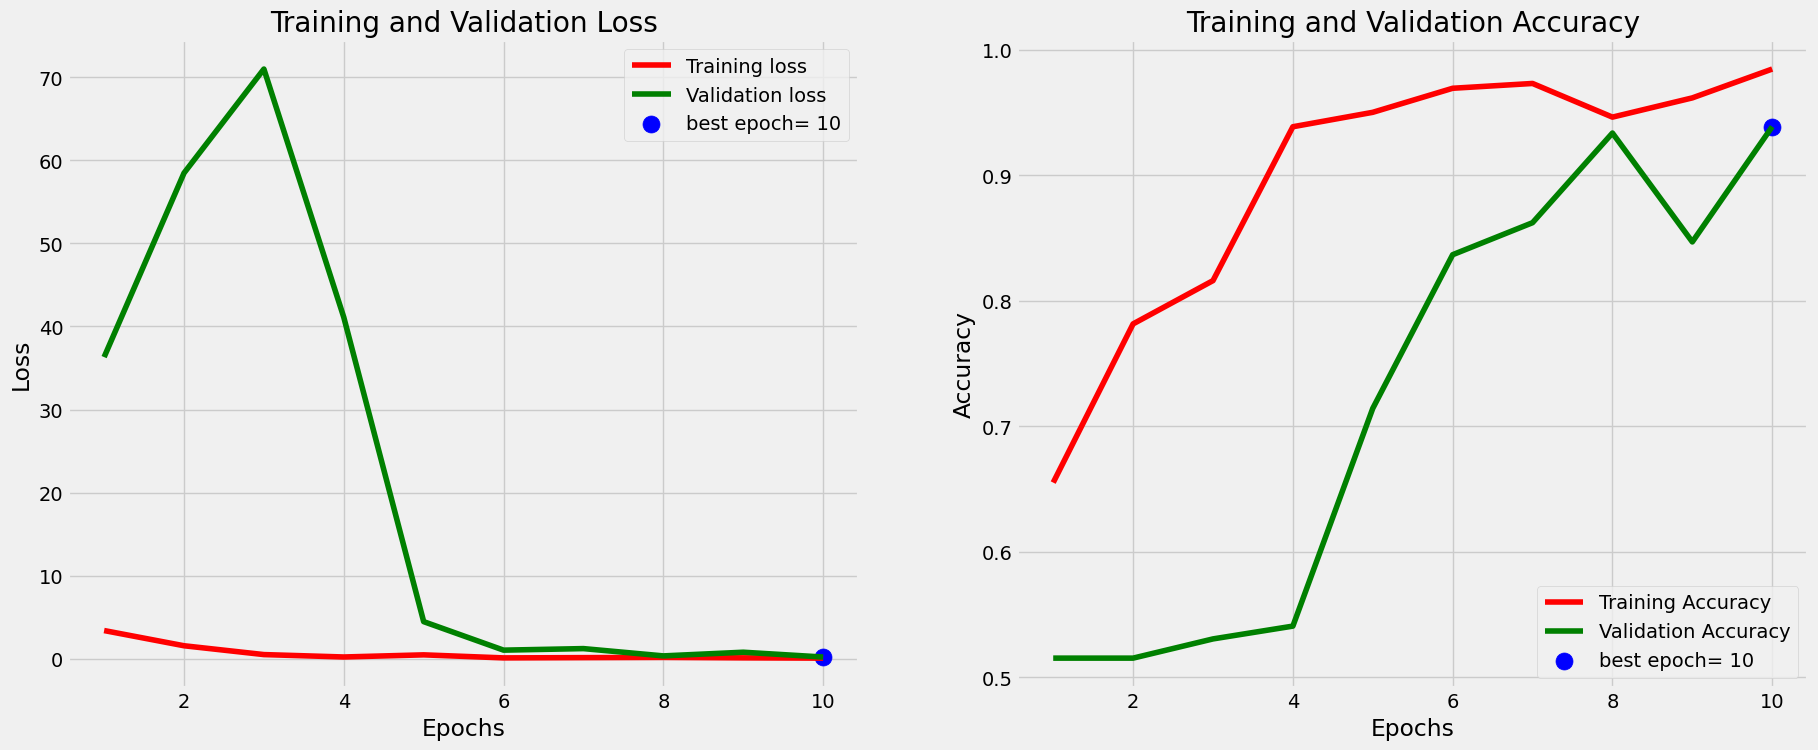

In [28]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [29]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9318 - loss: 0.1805  


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9387 - loss: 0.1940  
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8672 - loss: 0.5011   
Train Loss:  0.18397241830825806
Train Accuracy:  0.931034505367279
--------------------
Valid Loss:  0.19318027794361115
Valid Accuracy:  0.9387755393981934
--------------------
Test Loss:  0.4738917350769043
Test Accuracy:  0.8702290058135986


In [30]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 803ms/step


### confusion matrix for model 3

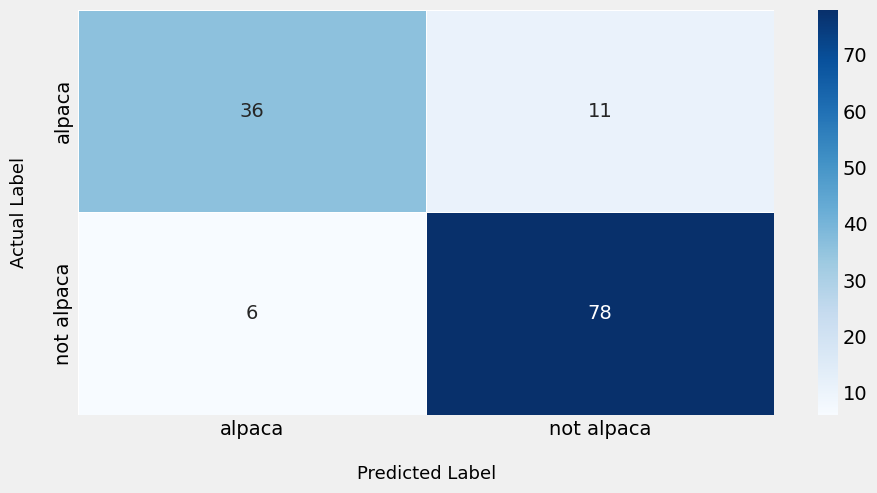

In [31]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);